In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_threshold_index(arr, threshold=1e-3, consecutive=2):
    for i in range(arr.shape[-1] - consecutive + 1):
        # support both 1D and 2D-with-single-row inputs
        row = arr if arr.ndim == 1 else arr[0]
        if np.all(row[i:i+consecutive] < threshold):
            return i
    return -1

In [3]:
# Noise parameters
noise_values = [0.8, 0.5, 0.1, 0.08, 0.05, 0.01]
noise_sorted = sorted(noise_values)
n_noise = len(noise_sorted)

# Methods
methods = ["FDODMD", "Baseline ODMD"]
n_methods = len(methods)
index_matrix = np.empty((n_noise, n_methods))

for i, noise in enumerate(noise_sorted):
    # File paths
    filename_denoising = f"./figsdata/Cr2_fourier_denoised_odmd_6_stacked_denoised_noise={noise}_Tmax=1500_overlap=0.2_dt=1.0_tol={noise}-{noise}_real_ODMD.npy"
    filename_baseline  = f"./figsdata/Cr2_baseline_odmd_noise={noise}_Tmax=1500_overlap=0.2_dt=1.0_real_ODMD.npy"
    
    # FDODMD
    try:
        data_denoising = np.load(filename_denoising)
        idx_denoising = find_threshold_index(data_denoising)
    except Exception as e:
        print(f"Error loading {filename_denoising}: {e}")
        idx_denoising = np.nan
    
    # Baseline ODMD
    try:
        data_baseline = np.load(filename_baseline)
        if noise == 0.1 and data_baseline.ndim > 1:
            idx_baseline = find_threshold_index(data_baseline[2, :].reshape(1, -1))
        else:
            idx_baseline = find_threshold_index(data_baseline)
    except Exception as e:
        print(f"Error loading {filename_baseline}: {e}")
        idx_baseline = np.nan
    index_matrix[i, 0] = idx_denoising * 5
    index_matrix[i, 1] = idx_baseline  * 5

# Mask out the sentinel value -5 by setting to NaN
index_matrix[index_matrix == -5] = np.nan

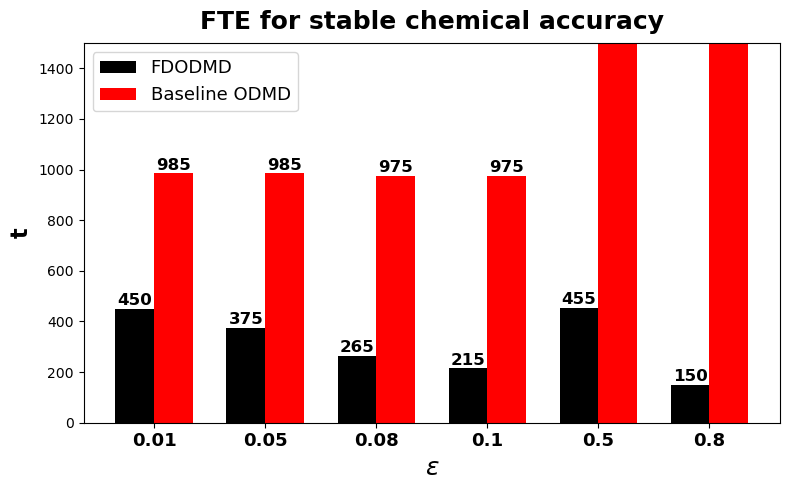

In [4]:
n_noise = index_matrix.shape[0]

fig, ax = plt.subplots(figsize=(8, 5))
width = 0.35
x = np.arange(n_noise)

valid_fd = ~np.isnan(index_matrix[:, 0])
ax.bar(
    x[valid_fd] - width/2,
    index_matrix[valid_fd, 0],
    width,
    label='FDODMD',
    color='black'
)

# Baseline ODMD – split into converged and non-converged
max_conv = np.nanmax(index_matrix[:, 1])
full_height = 1500

# converged runs
valid_base = ~np.isnan(index_matrix[:, 1])
ax.bar(
    x[valid_base] + width/2,
    index_matrix[valid_base, 1],
    width,
    label='Baseline ODMD',
    color='red'
)

# non-converged runs: full-height red bars, no legend entry
invalid_base = np.isnan(index_matrix[:, 1])
ax.bar(
    x[invalid_base] + width/2,
    np.full(invalid_base.sum(), full_height),
    width,
    color='red',
    label='_nolegend_'  # tells matplotlib not to add to the legend
)
ax.set_ylim(0, full_height)
ax.set_xticks(x)
ax.set_xticklabels([str(noise) for noise in noise_sorted], fontsize=13, fontweight='bold')
ax.set_xlabel(r"$\epsilon$", fontsize=18, fontweight='bold')
ax.set_ylabel("t", fontsize=16, fontweight='bold')
ax.set_title("FTE for stable chemical accuracy", fontsize=18, fontweight='bold', pad=10)
ax.legend(fontsize=13)

# Annotate only the real bars
for i in range(n_noise):
    # FDODMD
    h0 = index_matrix[i, 0]
    if not np.isnan(h0):
        ax.text(
            x[i] - width/2,
            h0 + full_height * 0.002,
            f"{h0:.0f}",
            ha='center', va='bottom',
            fontweight='bold', fontsize=12
        )
    # Baseline
    h1 = index_matrix[i, 1]
    if not np.isnan(h1):
        ax.text(
            x[i] + width/2,
            h1 + full_height * 0.002,
            f"{h1:.0f}",
            ha='center', va='bottom',
            fontweight='bold', fontsize=12
        )

plt.tight_layout()
plt.savefig('./figs/FTE_barplot_styled.pdf', bbox_inches='tight')
plt.show()